In [1]:
import numpy as np
import pandas as pd
import scipy
import scipy.interpolate
import copy
import sys

In [2]:
from ecoevocrm.consumer_resource_system import *
from ecoevocrm.consumer_resource_system import *
import ecoevocrm.utils as utils
import ecoevocrm.viz as viz
import ecoevocrm.coarse_graining as cg
import ecoevocrm.strain_pool as sp

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

----

# Main Parameters

In [4]:
J_NSTAR                 = 8   

In [5]:
ENV_ETA_STD             = 1e-8 

In [6]:
T_PERSIST               = 1e6  

In [7]:
NORMALIZE_PHENOTYPES    = True 

In [8]:
NUM_PERSISTENCE_WINDOWS = 10   

In [9]:
ENV_SEED                = 1 
J_SEED                  = 1 
DYNAMICS_SEED           = 2 
TRAITSUBSETS_SEED       = 1 
PERSISTENCEWINDOWS_SEED = 1 

In [10]:
ANALYSIS_ID             = 'example_grouppersistence'

~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [11]:
params = { 'J_NSTAR':                 J_NSTAR,
           'ENV_ETA_STD':             ENV_ETA_STD,
           'NORMALIZE_PHENOTYPES':    NORMALIZE_PHENOTYPES,
           'T_PERSIST':               T_PERSIST,
           'NUM_PERSISTENCE_WINDOWS': NUM_PERSISTENCE_WINDOWS,
           'ENV_SEED':                ENV_SEED,
           'J_SEED':                  J_SEED,
           'DYNAMICS_SEED':           DYNAMICS_SEED,  
           'TRAITSUBSETS_SEED':       TRAITSUBSETS_SEED,
           'PERSISTENCEWINDOWS_SEED': PERSISTENCEWINDOWS_SEED }

~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [12]:
runStr = f"{ANALYSIS_ID}_Jnstar{J_NSTAR}_EnvStd{ENV_ETA_STD}_seedJ{J_SEED}E{ENV_SEED}D{DYNAMICS_SEED}T{TRAITSUBSETS_SEED}P{PERSISTENCEWINDOWS_SEED}"
runStr

'example_grouppersistence_Jnstar8_EnvStd1e-08_seedJ1E1D2T1P1'

----

# Model parameters

In [13]:
T_adapt   = 1e5
T_persist = T_PERSIST
T_total   = T_adapt + T_persist
dt_env    = 1e3

## Traits

In [14]:
num_resources = 10

In [15]:
sigma = utils.binary_combinations(num_resources, exclude_all_zeros=True)
if(NORMALIZE_PHENOTYPES):
    sigma = sigma/sigma.sum(axis=1, keepdims=1)

## Environment

In [16]:
np.random.seed(ENV_SEED)

#### Adaptation Environment

In [17]:
rho_series_adapt = utils.brownian_series(T        = T_adapt, 
                                         dt       = dt_env, 
                                         L        = num_resources, 
                                         lamda    = 1e-3, 
                                         k        = 1e-8,
                                         eta_mean = 0, 
                                         eta_std  = ENV_ETA_STD, 
                                         y0       = 1, 
                                         v0       = 0, 
                                         return_interp = False)

#### Persistence Environment

In [18]:
rho_series_persist = utils.brownian_series(T        = T_persist * 1.5, 
                                           dt       = dt_env, 
                                           L        = num_resources, 
                                           lamda    = 1e-3, 
                                           k        = 1e-8,
                                           eta_mean = 0, 
                                           eta_std  = ENV_ETA_STD, 
                                           y0       = rho_series_adapt[0][:, -1].ravel(), 
                                           v0       = 0, 
                                           return_interp = False)

In [19]:
rho_series = scipy.interpolate.interp1d(np.hstack([rho_series_adapt[1], T_adapt+rho_series_persist[1]]), np.hstack([rho_series_adapt[0], rho_series_persist[0]]))

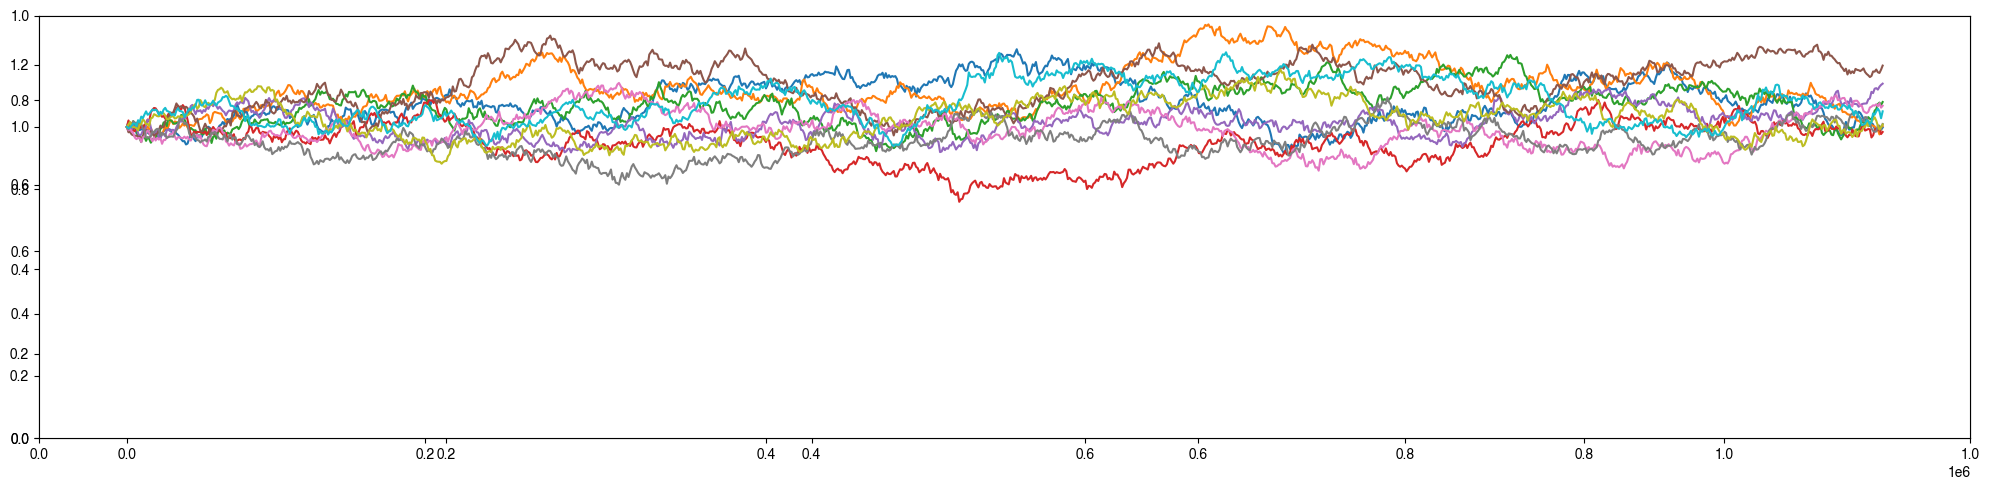

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
viz.interp_series_plot(rho_series, t_vals=np.arange(0, T_total, step=dt_env))
fig.tight_layout()
# fig.savefig(f"{runStr}_FIG_resourcesrhoseries.png", facecolor='white')

## Costs

### Baseline Trait Costs

In [21]:
chi = 0.5

### Linear Trait Costs

In [22]:
xi = 0.1

### Trait Interaction Costs

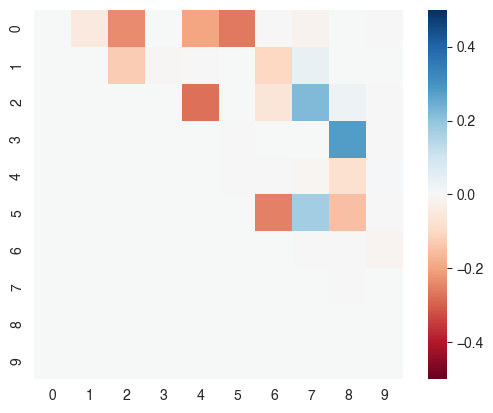

In [23]:
J = utils.random_matrix((num_resources, num_resources), 'tikhonov_sigmoid_ordered', args={'J_0': 0.3, 'n_star': J_NSTAR, 'delta': 3}, triangular=True, diagonal=0, ordered=True, seed=J_SEED)
viz.matrix_plot(J, vmin=-0.5, vmax=0.5)

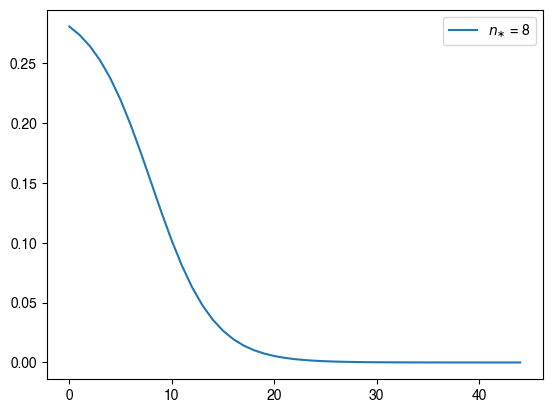

In [24]:
plt.plot(range(len(J[J!=0])), np.sort(np.abs(J[J!=0]))[::-1], label="$n_{\\ast}$ = "+str(J_NSTAR)) 
plt.legend()
plt.show() 

------

## Run system

In [25]:
system = ConsumerResourceSystem(type_set=TypeSet(sigma=sigma[0], xi=xi, chi=chi, J=J, mu=1e-10, 
                                                 normalize_phenotypes=NORMALIZE_PHENOTYPES, binarize_traits_chi_cost_terms=False, binarize_traits_J_cost_terms=True), 
                                resource_set=ResourceSet(num_resources=num_resources, rho=rho_series), 
                                N_init=1, R_init=1, 
                                convergent_lineages=False, 
                                max_time_step=dt_env,
                                seed=DYNAMICS_SEED,
                                check_event_low_abundance=False)

In [26]:
system.run(T=T_total)

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


KeyboardInterrupt: 

In [ ]:
system.reorder_types()

In [ ]:
type_colors = viz.color_types_by_phylogeny(system.type_set, color_step_start=0.13, color_step_slope=0.01, color_step_min=0.02)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
viz.stacked_abundance_plot(system, ax=ax, relative_abundance=True, t_max=T_total, log_x_axis=False, t_downsample=100, type_colors=type_colors)
fig.tight_layout()
# fig.savefig(f"{runStr}_FIG_communitytrajectory.png", facecolor='white')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
viz.phylogeny_plot(system, ax=ax, log_x_axis=True, type_colors=type_colors)
fig.tight_layout()
# fig.savefig(f"{runStr}_FIG_communityphylogeny.png", facecolor='white', dpi=400)

In [ ]:
stop

-------

# Summary statistics

In [ ]:
stats = {}

#### Simulation stats

In [ ]:
stats.update({  
                'T_adapt':          T_adapt,
                'T_persist':        T_persist,
                'T_total':          T_total,
                'dt_env':           dt_env
             })

#### Environment stats

In [ ]:
for i in range(rho_series_persist[0].shape[0]):
    stats.update(utils.get_stats(rho_series_persist[0][i], prefix=f"resource{i+1}_abundance"))
    stats.update({f"resource{i+1}_abundance_final": rho_series_persist[0][i][-1]})

#### Cost stats

In [ ]:
stats.update(utils.get_stats(J[J!=0], prefix=f"Jijelements"))

In [ ]:
stats.update(utils.get_stats(system.type_set.energy_costs, prefix=f"cost_exploredtypes"))
stats.update(utils.get_stats(system.type_set.xi_cost_terms, prefix=f"cost_xi_exploredtypes"))
stats.update(utils.get_stats(system.type_set.chi_cost_terms, prefix=f"cost_chi_exploredtypes"))
stats.update(utils.get_stats(system.type_set.J_cost_terms, prefix=f"cost_J_exploredtypes"))

In [ ]:
stats.update(utils.get_stats(system.extant_type_set.energy_costs, prefix=f"cost_extanttypes"))
stats.update(utils.get_stats(system.extant_type_set.xi_cost_terms, prefix=f"cost_xi_extanttypes"))
stats.update(utils.get_stats(system.extant_type_set.chi_cost_terms, prefix=f"cost_chi_extanttypes"))
stats.update(utils.get_stats(system.extant_type_set.J_cost_terms, prefix=f"cost_J_extanttypes"))

#### Population stats

In [ ]:
# resource_demand = system.get_resource_demand(t_index=list(range(len(system.t_series))))
# for i in range(system.num_resources):
#     stats.update(utils.get_stats(resource_demand[i], prefix=f"resource{i+1}_demand"))
#     stats.update({f"resource{i+1}_demand_final": resource_demand[i][-1]})

In [ ]:
# biomass = system.get_biomass(t_index=list(range(len(system.t_series))))
# stats.update(utils.get_stats(biomass, prefix=f"biomass"))
# stats.update({f"biomass_final": biomass[-1]})

In [ ]:
# num_extant_types = system.get_num_extant_types(t_index=list(range(len(system.t_series))))
# stats.update(utils.get_stats(num_extant_types, prefix=f"num_extant_types"))
# stats.update({f"num_extant_types_final": num_extant_types[-1]})

In [ ]:
# num_extant_phenotypes = system.get_num_extant_phenotypes(t_index=list(range(len(system.t_series))))
# stats.update(utils.get_stats(num_extant_phenotypes, prefix=f"num_extant_phenotypes"))
# stats.update({f"num_extant_phenotypes_final": num_extant_phenotypes[-1]})

In [ ]:
lineage_depths = system.type_set.get_lineage_depths()
stats.update(utils.get_stats(lineage_depths, prefix=f"lineage_depth_final"))

In [ ]:
# mean_traits_per_type_overtime = system.get_num_traits_per_type(t_index=list(range(len(system.t_series))), summary_stat='mean')
# stats.update(utils.get_stats(mean_traits_per_type_overtime, prefix=f"mean_traits_per_type_overtime"))

In [ ]:
# traits_per_type_final = system.get_num_traits_per_type()
# stats.update(utils.get_stats(traits_per_type_final, prefix=f"traits_per_type_final"))

--

In [ ]:
stats.update(params)

In [ ]:
df_summarystats = pd.DataFrame([stats])
df_summarystats

In [ ]:
# df_summarystats.to_csv(f"{runStr}_RESULTS_summarystats.csv")

-------

# Measure Trait Correlations

In [ ]:
from statsmodels.stats.weightstats import DescrStatsW

In [ ]:
data_correlations = []

In [ ]:
def get_correlation_dicts(corr_matrix, corr_traits, corr_weights, store_Jij_vals=False, params_dict=None):
    dicts = []
    for u in range(len(np.triu_indices(num_resources, k=1)[0])):
        i = np.triu_indices(num_resources, k=1)[0][u]
        j = np.triu_indices(num_resources, k=1)[1][u]  
        corrVal  = corr_matrix[i,j]
        corrDict = { 'corr_traits':     corr_traits,
                     'corr_weights':    corr_weights,
                     'trait_i':         i,
                     'trait_j':         j,
                     'correlation':     corrVal,
                     'correlation_abs': np.abs(corrVal) }
        if(store_Jij_vals):
            corrDict.update({'Jij': J[i,j]})
        if(params_dict is not None):
            corrDict.update(params_dict)
        dicts.append(corrDict)
    return dicts

### Ecological trait correlations

In [ ]:
final_abundances = system.N_series[:, -1]
final_abundances /= final_abundances.sum()
mean_abundances  = np.mean(system.N_series[:], axis=1)
mean_abundances /= mean_abundances.sum()

In [ ]:
plt.hist(mean_abundances, bins=100)
plt.yscale('log')
plt.show()

In [ ]:
scipy.stats.entropy(mean_abundances)

#### Binarized trait correlations

In [ ]:
traitCorr_bnryTraits_wtEcoMeanAbd = np.triu( DescrStatsW((system.type_set.sigma > 0).astype(int), weights=mean_abundances).corrcoef, k=1)

In [ ]:
data_correlations += get_correlation_dicts(traitCorr_bnryTraits_wtEcoMeanAbd, corr_traits='binary', corr_weights='ecology_mean_abundance', store_Jij_vals=True, params_dict=params)

In [ ]:
viz.matrix_plot(traitCorr_bnryTraits_wtEcoMeanAbd)

#### Normalized trait correlations

In [ ]:
traitCorr_normTraits_wtEcoMeanAbd = np.triu( DescrStatsW(system.type_set.sigma, weights=mean_abundances).corrcoef, k=1)

In [ ]:
data_correlations += get_correlation_dicts(traitCorr_bnryTraits_wtEcoMeanAbd, corr_traits='normalized', corr_weights='ecology_mean_abundance', store_Jij_vals=True, params_dict=params)

In [ ]:
viz.matrix_plot(traitCorr_normTraits_wtEcoMeanAbd)

### Intrinsic (non-ecology) trait correlations

Get the "intrinsic fitness" of all types that were explored: The growth rate of each type at low density (n=1) in the resource environment at t=0

In [ ]:
f_intrinsic = system.get_fitness(t=0, N=np.ones(system.type_set.sigma.shape[0]))

In [ ]:
plt.hist(f_intrinsic, bins=100)
plt.yscale('log')
plt.show()

Calculate a Boltzmann distribution based on intrinsic fitnesses, with entropy matching the entropy of the ecological strain pool

In [ ]:
def test_boltzmann_temp_for_entropy(energy, target_entropy):
    import scipy
    def entropy_diff(beta, energy, target_entropy):
        # boltzmann_dist = np.exp(-beta * energy.astype(np.float128))
        # boltzmann_dist = boltzmann_dist.astype(np.float64)
        # boltzmann_dist /= boltzmann_dist.astype(np.float128).sum()
        boltzmann_dist = ( np.exp(-beta * energy.astype(np.float128)) / np.sum(np.exp(-beta * energy.astype(np.float128))) ).astype(np.float64)
        boltzmann_entropy = scipy.stats.entropy(boltzmann_dist)
        # print("beta", beta, "boltzmann_entropy", boltzmann_entropy, "target_entropy", target_entropy)
        return np.abs(boltzmann_entropy - target_entropy)
    res = scipy.optimize.minimize(entropy_diff, x0=1, args=(energy, target_entropy), method='Nelder-Mead')
    beta_fit = res['x'][0]
    return beta_fit

In [ ]:
entropy_ecology = scipy.stats.entropy(mean_abundances)

In [ ]:
temp = test_boltzmann_temp_for_entropy(energy=-1*f_intrinsic, target_entropy=entropy_ecology)

In [ ]:
boltzmann_intrinsic = ( np.exp(temp * f_intrinsic.astype(np.float128))/np.sum(np.exp(temp * f_intrinsic.astype(np.float128))) ).astype(np.float64)

In [ ]:
boltzmann_intrinsic[boltzmann_intrinsic == 0] += sys.float_info.min 

In [ ]:
plt.hist(boltzmann_intrinsic, bins=100)
plt.yscale('log')
plt.show()

In [ ]:
scipy.stats.entropy(boltzmann_intrinsic)

#### Binarized trait correlations

In [ ]:
traitCorr_bnryTraits_wtBoltzmann = np.triu( DescrStatsW((system.type_set.sigma > 0).astype(int), weights=boltzmann_intrinsic).corrcoef, k=1)

In [ ]:
data_correlations += get_correlation_dicts(traitCorr_bnryTraits_wtBoltzmann, corr_traits='binary', corr_weights='intrinsic_fitness_boltzmann', store_Jij_vals=True, params_dict=params)

In [ ]:
viz.matrix_plot(traitCorr_bnryTraits_wtBoltzmann)

#### Normalized trait correlations

In [ ]:
traitCorr_normTraits_wtBoltzmann = np.triu( DescrStatsW(system.type_set.sigma, weights=boltzmann_intrinsic).corrcoef, k=1)

In [ ]:
data_correlations += get_correlation_dicts(traitCorr_bnryTraits_wtBoltzmann, corr_traits='normalized', corr_weights='intrinsic_fitness_boltzmann', store_Jij_vals=True, params_dict=params)

In [ ]:
viz.matrix_plot(traitCorr_normTraits_wtBoltzmann)

In [ ]:
df_correlations = pd.DataFrame(data_correlations)
df_correlations

In [ ]:
df_correlations.to_csv(f"{runStr}_RESULTS_traitcorrelations.csv")

In [ ]:
stats.update({'entorpy_wtEcoMeanAbd': scipy.stats.entropy(mean_abundances),
              'entropy_wtBoltzmann':  scipy.stats.entropy(boltzmann_intrinsic)})
df_summarystats.to_csv(f"{runStr}_RESULTS_summarystats.csv")

In [ ]:
# stop

-------

# Measure group persistences

In [ ]:
from itertools import chain, combinations

In [ ]:
np.random.seed(TRAITSUBSETS_SEED)

In [ ]:
traits = list(range(num_resources))
all_trait_subsets = list( chain.from_iterable(combinations(traits, r) for r in range(1, len(traits)+1)) )

ordered_trait_subsets = [list(range(l)) for l in range(1, num_resources+1)]
ordered_trait_subsets

trait_subsets = ordered_trait_subsets
# trait_subsets = all_trait_subsets
# trait_subsets = np.random.choice(all_trait_subsets, size=100, replace=False)
# trait_subsets = np.append(trait_subsets, [range(1, num_resources+1)])

# trait_subsets = []
# for n in range(1, num_resources+1):
#     subsets_with_n_traits = []
#     for subset in all_trait_subsets:
#         if(len(subset) == n):
#             subsets_with_n_traits.append(subset)
#     selected_subsets_indices = np.random.choice(range(len(subsets_with_n_traits)), size=min(10, len(subsets_with_n_traits)), replace=False)
#     for idx in selected_subsets_indices:
#         trait_subsets.append(subsets_with_n_traits[idx])
# print(trait_subsets)
# exit()

# trait_subsets

In [ ]:
max_phylo_depth = stats['lineage_depth_final_max']
max_phylo_depth

### Persistence over Random Windows

In [ ]:
np.random.seed(PERSISTENCEWINDOWS_SEED)

In [ ]:
numRandWindows = NUM_PERSISTENCE_WINDOWS

In [ ]:
window_lengths = [1e6, 5e5, 1e5, 5e4, 1e4]

In [ ]:
data_persistence = []

In [ ]:
for Dt in window_lengths:

    tf_min = T_adapt+Dt
    tf_max = T_total

    tf_vals = np.random.uniform(low=tf_min, high=tf_max, size=numRandWindows)

    for i, tf in enumerate(tf_vals):

        t0 = max(T_adapt, tf-Dt)

        depths = range(1, max_phylo_depth+1)
        for d, depth in enumerate(depths):
            
            # print("depth =", depth)
            
            for mode in ['branchings', 'coalescings']:
                
                print(f"Dt: {Dt}, window {i+1}/{len(tf_vals)}, ({t0}, {tf}): {mode} phylo_depth {depth}/{max_phylo_depth}")
            
                phylogroup_persistence = cg.phylogenetic_group_turnover(system, phylogeny_depth=depth, t0=t0, tf=tf, inverse=True, mode=mode)
                phylogroup_entropy_t0  = cg.phylogenetic_group_diversity(system, phylogeny_depth=depth, t=t0, metric='shannon', mode=mode)
                phylogroup_entropy_tf  = cg.phylogenetic_group_diversity(system, phylogeny_depth=depth, t=tf, metric='shannon', mode=mode)
                persistence_dict       = {'group_type': 'phylo_'+mode,
                                          'depth': depth,
                                          'window_num': i+1,
                                          't0': t0,
                                          'tf': tf,
                                          'Dt': tf-t0,
                                          'persistence': phylogroup_persistence,
                                          'entropy_t0':  phylogroup_entropy_t0,
                                          'entropy_tf':  phylogroup_entropy_tf}
                persistence_dict.update(params)
                data_persistence.append(persistence_dict)
                
                #---------------------------
        
                df_persistence = pd.DataFrame(data_persistence)
                df_persistence.to_csv(f"{runStr}_RESULTS_grouppersistences.csv")


        for s, trait_subset in enumerate(trait_subsets):
            
            print(f"Dt: {Dt}, window {i+1}/{len(tf_vals)}, ({t0}, {tf}): trait_subset {s+1}/{len(trait_subsets)} ({trait_subset})")
            
            # traitgroup_persistence = test_functional_group_turnover(system, trait_subset=trait_subset, t0=t0, tf=tf, inverse=True)
            traitgroup_persistence = cg.functional_group_turnover(system, trait_subset=trait_subset, t0=t0, tf=tf, inverse=True)
            traitgroup_entropy_t0  = cg.functional_group_diversity(system, trait_subset=trait_subset, t=t0, metric='shannon')
            traitgroup_entropy_tf  = cg.functional_group_diversity(system, trait_subset=trait_subset, t=tf, metric='shannon')
            persistence_dict       = {'group_type': 'func',
                                      'trait_subset': '-'.join([str(trait) for trait in trait_subset]),
                                      'num_traits': len(trait_subset),
                                      'window_num': i+1,
                                      't0': t0,
                                      'tf': tf,
                                      'Dt': tf-t0,
                                      'persistence': traitgroup_persistence,
                                      'entropy_t0':  traitgroup_entropy_t0,
                                      'entropy_tf':  traitgroup_entropy_tf }
            persistence_dict.update(params)
            data_persistence.append(persistence_dict)
            
            #---------------------------
        
            df_persistence = pd.DataFrame(data_persistence)
            df_persistence.to_csv(f"{runStr}_RESULTS_grouppersistences.csv")


In [ ]:
df_persistence

In [ ]:
df_persistence.to_csv(f"{runStr}_RESULTS_grouppersistences.csv")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 9))
# sns.lineplot(ax=ax, data=df_persistence[df_persistence['group_type'] == 'phylo_branchings'], 
#              x='Dt', y='persistence', hue='depth', palette='Greens_r',
#              hue_order=depths)
# sns.lineplot(ax=ax, data=df_persistence[df_persistence['group_type'] == 'phylo_coalescings'], 
#              x='Dt', y='persistence', hue='depth', palette='Blues',
#              hue_order=depths)
sns.lineplot(ax=ax, data=df_persistence[df_persistence['group_type'] == 'func'], 
             x='Dt', y='persistence', hue='num_traits', palette='Purples_r',
             hue_order=depths)
ax.set_xlim(xmin=0)
ax.set_ylim(ymin=0, ymax=1)
sns.despine()
# fig.savefig(outdir+treatmentStr+"_persistence_randomWindows.png")

In [ ]:
for Dt in np.sort(df_persistence['Dt'].unique()):
    print(Dt)
    fig, ax = plt.subplots(1, 1, figsize=(16, 16))

    sns.scatterplot(ax=ax, data=df_persistence[(df_persistence['group_type'] == 'func') & (df_persistence['Dt'] == Dt)], 
                    x='entropy_t0', y='persistence', hue='num_traits', palette='Reds_r', ec='k')
    sns.scatterplot(ax=ax, data=df_persistence[(df_persistence['group_type'] == 'phylo_branchings') & (df_persistence['Dt'] == Dt)], 
                    x='entropy_t0', y='persistence', hue='depth', palette='Greens_r', ec='k')
    sns.scatterplot(ax=ax, data=df_persistence[(df_persistence['group_type'] == 'phylo_coalescings') & (df_persistence['Dt'] == Dt)], 
                    x='entropy_t0', y='persistence', hue='depth', palette='Blues', ec='k')
    ax.set_xlim(xmin=0, xmax=df_persistence['entropy_t0'].max()*1.05)

    ax.set_ylim(ymin=0, ymax=1.02)
    ax.legend(loc='lower left')
    sns.despine()
    # fig.savefig(outdir+treatmentStr+f"_entropyXpersistence_randomWindows_Dt{int(Dt)}.png")
    # plt.close()
    plt.show()

-------

In [ ]:
sns.set_context('paper')

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6),
                       gridspec_kw={
                           'width_ratios': [3, 11],
                           'height_ratios': [2.25, 3.75],
                       'wspace': 0.175,
                       'hspace': 0.1})


axes[0, 0].axis('off')


################################################


ax = axes[0, 1]

sns.set_context('paper')

palette = sns.color_palette('terrain', 12)[:10]

t_vals=np.arange(0, T_total, step=dt_env)
for i in range(num_resources):
    ax.plot(t_vals, rho_series(t_vals)[i, :], color=palette[i], lw=2)

# ax.set_ylim(ymin=min(0, np.min(rho_series(t_vals))))
ax.set_xlim(0, t_vals.max())
ax.set_xticks([])
ax.set_yticks([0, 0.5, 1, 1.5])
ax.set_yticklabels(['', '', 1, ''], fontsize=13)
ax.set_xlabel(None)
ax.set_ylabel("resource influxes", fontsize=16)

ax.set_xticks([])

# The spines
plt.setp(ax.spines.values(), linewidth=1)

# The ticks
ax.xaxis.set_tick_params(width=1)
ax.yaxis.set_tick_params(width=1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


################################################


ax = axes[1, 0]

viz.matrix_plot(J, ax=ax, vmin=-0.5, vmax=0.5, cbar=False, linewidths=1, linecolor='w')

ax.set_xticks([])
ax.set_yticks([])

ax.set_title('trait interactions',  fontsize=16)


################################################


ax = axes[1, 1]

viz.stacked_abundance_plot(system, ax=ax, relative_abundance=True, t_max=T_total-T_adapt, log_x_axis=False, t_downsample=100, type_colors=type_colors) #, linewidth=2, edgecolor='w')

ax.set_xlabel('time $\\rightarrow$', fontsize=16)
ax.set_ylabel('rel. abundance of types', fontsize=16)

ax.set_yticks([0, 1])
ax.set_xticks([])

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

ax.set_xlim(xmin=0, xmax=1e6)
ax.set_ylim(ymin=0, ymax=1)

# sns.despine()

# The spines
plt.setp(ax.spines.values(), linewidth=1)

# The ticks
ax.xaxis.set_tick_params(width=1)
ax.yaxis.set_tick_params(width=1)

# fig.tight_layout()

# fig.savefig(f"./poster_figs/community_trajectory_big_withJij.png", facecolor='white', dpi=400)